```
ID: 0710018
Name: 張宸愷
```

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# read wheat seeds dataset
seeds = pd.read_table("data/seeds_dataset.txt",
                      header=None, sep='\t+', engine='python')
# read ionosphere dataset
ionosphere = pd.read_csv("data/ionosphere.data", header=None, sep=',')

seeds_orig = seeds.to_numpy()
ionosphere_orig = ionosphere.to_numpy()

np.random.shuffle(seeds_orig)
np.random.shuffle(ionosphere_orig)

# X_seeds = scale(seeds_orig[:, 0:-1], axis=0)
# X_iono = scale(ionosphere_orig[:, 0:-1], axis=0)


def r2np(r: dict, clss: list) -> np.ndarray:
    o = np.zeros((len(clss),  3), dtype=np.float64)
    for i, c in enumerate(clss):
        c = str(c)
        o[i] = [r[c]["precision"], r[c]["recall"], r["accuracy"]]

    return o
    

In [51]:
# K-means clustering


class Kmeans:

    centers = None

    def __init__(self, K) -> None:
        self.K = K

    def predict(self, X: np.ndarray) -> np.ndarray:
        feature_num = X.shape[1]
        self.low = [X[:, i].min() for i in range(feature_num)]
        self.high = [X[:, i].max() for i in range(feature_num)]
        self.centers = np.zeros((self.K, feature_num), dtype=np.float64)
        for a in range(self.K):
            # generate uniform distribution for every feature with
            # the interval being [feature.min(), feature.max()]
            self.centers[a] = [np.random.uniform(
                low=self.low[i], high=self.high[i]) for i in range(feature_num)]
        dis = np.ones((self.K, feature_num), dtype=np.float64)
        while np.sum(dis) > 1e-7:  # loop until centers don't change
            assign = self.__assign(X)  # get new assignment
            new_c = self.__update(X, assign)  # get new center

            # get summation of center difference
            dis = np.sum(np.abs(new_c - self.centers))
            self.centers = new_c  # assing new center

        return assign

    def __update(self, X, assign):
        new_cen = np.zeros((self.K, X.shape[1]))
        for i in range(self.K):
            mask: np.ndarray = np.where(
                assign == i, 1, 0)  # get points in group i
            ss = np.moveaxis(X, 0, -1) * mask  # transpose X to broadcast mask
            ss = np.moveaxis(ss, 0, -1)  # transpose X back
            div = np.sum(mask)  # num samples in mask
            if div == 0:
                # in case the center doesn't have any points,
                # we reinitialize the center
                new_cen[i] = [np.random.uniform(
                    low=self.low[i], high=self.high[i]) for i in range(X.shape[1])]
            else:
                new_cen[i] = (np.sum(ss, axis=0) / div)  # get new center
        return new_cen

    def __assign(self, X) -> np.ndarray:
        dis = np.zeros((X.shape[0], self.K), dtype=np.float64)
        for i in range(self.K):
            # calculate Euclidean distance with center
            t = np.sum((X - self.centers[i])**2, axis=1).astype(np.float64)
            dis[:, i] = np.sqrt(t)
        return dis.argmin(axis=1)  # decide which set it belongs to


km = Kmeans(3)
p = km.predict(seeds_orig[:, 0:-1])

# assign the labels to the unlabeled groups
mm = np.zeros((3, 3), dtype=np.int64)
for i in range(3):
    for j in range(3):
        label_i = np.argwhere(p == i)
        a = seeds_orig[:, -1][label_i] == j+1
        mm[i, j] = np.count_nonzero(a)

trans = np.argmax(mm, axis=1)  # obtain the tranformation dictionary

pred = np.array([trans[x]+1 for x in p])  # transform

r = classification_report(
    seeds_orig[:, -1], pred, labels=[1, 2, 3], output_dict=True)
confm = confusion_matrix(seeds_orig[:, -1], pred)

print("metrices:\n")
df = pd.DataFrame(index=[1, 2, 3], columns=[
                  "precision", "recall", "accuracy"], data=r2np(r, [1, 2, 3]))

print(df)
print()
print("confusion matrix:\n")
df = pd.DataFrame(index=[str(i+1)+" (true)" for i in range(3)],
                  columns=[str(i+1) + " (pred)" for i in range(3)], data=confm)
print(df)


metrices:

   precision    recall  accuracy
1   0.850746  0.814286  0.890476
2   0.983607  0.857143  0.890476
3   0.853659  1.000000  0.890476

confusion matrix:

          1 (pred)  2 (pred)  3 (pred)
1 (true)        57         1        12
2 (true)        10        60         0
3 (true)         0         0        70


In [52]:
# SVM

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(
    ionosphere_orig[:, 0:-1], ionosphere_orig[:, -1], test_size=0.3) # holdout

#----------------linear---------------------
cls = SVC(kernel='linear')

cls.fit(X_train, y_train)
pred = cls.predict(X_test)

r = classification_report(y_test, pred, labels=['b', 'g'], output_dict=True)
confm = confusion_matrix(y_test, pred, labels=['b', 'g'])
print("Linear Kernel:")
print("metrices:\n")
df = pd.DataFrame(index=[1, 2], columns=[
                  "precision", "recall", "accuracy"], data=r2np(r, ['b', 'g']))

print(df)
print()
print("confusion matrix:\n")
df = pd.DataFrame(index=[str(i)+" (true)" for i in ['b', 'g']],
                  columns=[str(i) + " (pred)" for i in ['b', 'g']], data=confm)
print(df)
print()
#----------------linear---------------------

#----------------rbf---------------------

cls = SVC(kernel='rbf', gamma=0.286)
cls.fit(X_train, y_train)
pred = cls.predict(X_test)

r = classification_report(y_test, pred, labels=['b', 'g'], output_dict=True)
confm = confusion_matrix(y_test, pred, labels=['b', 'g'])
print("RBF Kernel:")
print("metrices:\n")
df = pd.DataFrame(index=[1, 2], columns=[
                  "precision", "recall", "accuracy"], data=r2np(r, ['b', 'g']))

print(df)
print()
print("confusion matrix:\n")
df = pd.DataFrame(index=[str(i)+" (true)" for i in ['b', 'g']],
                  columns=[str(i) + " (pred)" for i in ['b', 'g']], data=confm)
print(df)
print()
#----------------rbf---------------------



#----------------poly---------------------
cls = SVC(kernel='poly', gamma=5.005, degree=5, coef0=1)
cls.fit(X_train, y_train)
pred = cls.predict(X_test)

r = classification_report(y_test, pred, labels=['b', 'g'], output_dict=True)
confm = confusion_matrix(y_test, pred, labels=['b', 'g'])
print("Polynomial Kernel:")
print("metrices:\n")
df = pd.DataFrame(index=[1, 2], columns=[
                  "precision", "recall", "accuracy"], data=r2np(r, ['b', 'g']))

print(df)
print()
print("confusion matrix:\n")
df = pd.DataFrame(index=[str(i)+" (true)" for i in ['b', 'g']],
                  columns=[str(i) + " (pred)" for i in ['b', 'g']], data=confm)
print(df)
print()
#----------------poly---------------------



Linear Kernel:
metrices:

   precision    recall  accuracy
1   0.848485  0.800000  0.886792
2   0.904110  0.929577  0.886792

confusion matrix:

          b (pred)  g (pred)
b (true)        28         7
g (true)         5        66

RBF Kernel:
metrices:

   precision    recall  accuracy
1   0.918919  0.971429  0.962264
2   0.985507  0.957746  0.962264

confusion matrix:

          b (pred)  g (pred)
b (true)        34         1
g (true)         3        68

Polynomial Kernel:
metrices:

   precision    recall  accuracy
1   0.903226  0.800000   0.90566
2   0.906667  0.957746   0.90566

confusion matrix:

          b (pred)  g (pred)
b (true)        28         7
g (true)         3        68



# Comparison & Conclusion
The RBF kernel performs the best, followed by polynomial kernel and lastly, linear kernel. For the K-means clustering, I sometimes observe that there were only two clusters. My guess is that when randomly initializing the centroids, one centroid ended up not being assigned any children, thus ended up as a point outside of the group. I fixed this issue by adding a condition that if this happens, the lonely centroid will be randomly initialized again. 

# Questions
## K-means clustering
> Choose two features to execute your K-means function and draw a scatter plot with the computed centers and the predicted label for each instance. - 10%
## A:


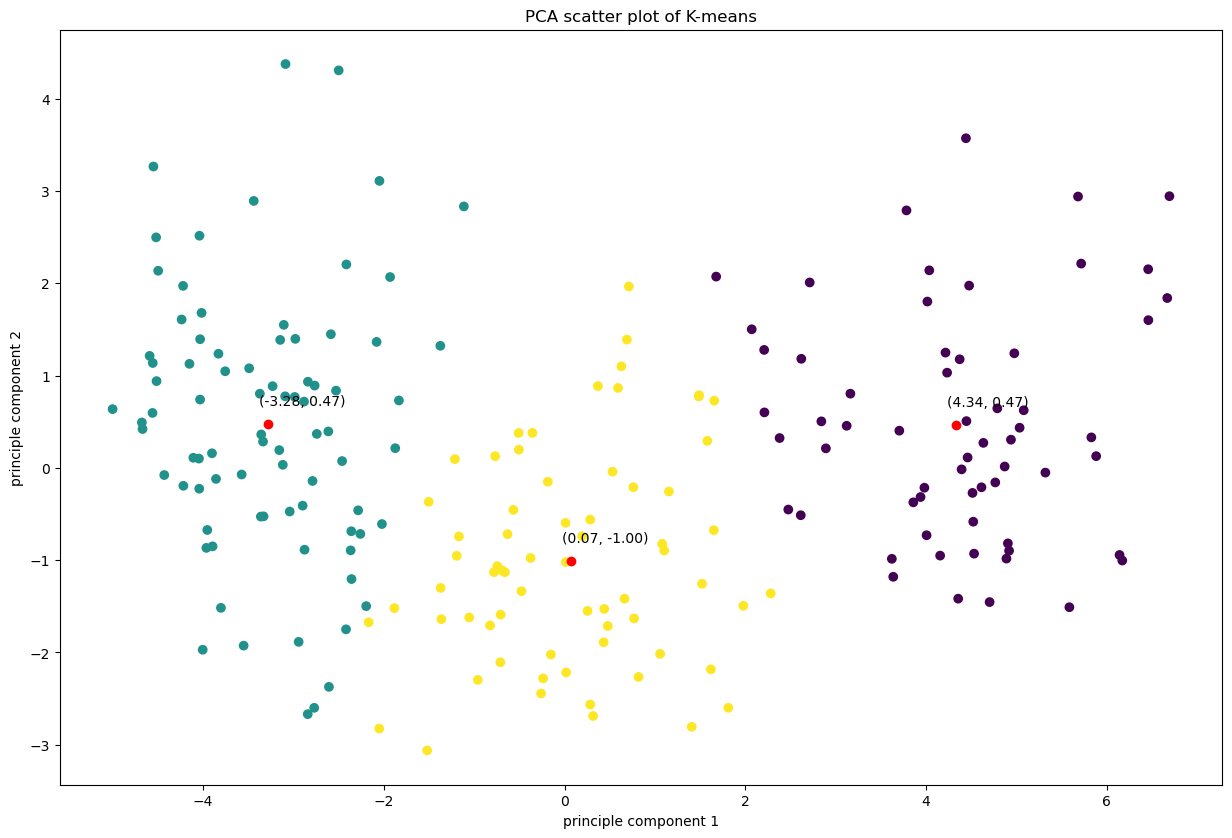

In [53]:
from sklearn.decomposition import PCA


pc = PCA(n_components=2)
X = pc.fit_transform(seeds_orig[:,0:-1])

km = Kmeans(K=3)
pred = km.predict(X)

fig = plt.figure(figsize=(15,10), dpi=100)

s = plt.scatter(X[:,0], X[:,1], c=pred)
_= plt.scatter(km.centers[:,0], km.centers[:,1], c='red')
plt.title("PCA scatter plot of K-means")
plt.xlabel("principle component 1")
plt.ylabel("principle component 2")
for i in range(3):
    _ = plt.text(km.centers[i,0]-0.1, km.centers[i,1]+0.2, "({:.2f}, {:.2f})".format(km.centers[i,0], km.centers[i,1]))

## Support Vector Machine
> Show the average performance of K-fold cross-validation of parameter search in tables for each kernel. - 10%


In [ ]:
# grid search
from sklearn.model_selection import ParameterGrid

m1 = np.linspace(0.01, 2.5, 10)
perf = np.zeros((2, 10))
for i, m in enumerate(m1):
    cls = SVC(kernel='rbf', gamma=m)
    k = KFold(n_splits=5)
    acc = 0
    for train, test in k.split(X_train, y_train):
        X_tra, y_tra = X_train[train], y_train[train]
        X_te, y_te = X_train[test], y_train[test]
        cls.fit(X_tra, y_tra)
        p = cls.predict(X_te)
        r = classification_report(y_te, p, output_dict=True)
        acc += r["accuracy"]
    acc /= 5
    perf[:, i] = [m, acc]
df = pd.DataFrame(index=['gamma', 'accuracy'], data=perf)
print("rbf\n")
print(df.to_markdown())
print()

mm = [np.linspace(0.01, 10, 5), np.linspace(-10, 1, 5),
      np.linspace(1, 5, 5)]
params = {"gamma": mm[0], "coef0": mm[1], "degree": mm[2]}
pg = ParameterGrid(params)


perf = np.zeros((4, 125))
for i, m in enumerate(pg):
    gamma = m["gamma"]
    coef0 = m["coef0"]
    degree = m["degree"]
    cls = SVC(kernel='poly', gamma=m["gamma"],
              coef0=m["coef0"], degree=m["degree"])
    k = KFold(n_splits=5)
    acc = 0
    for train, test in k.split(X_train, y_train):
        X_tra, y_tra = X_train[train], y_train[train]
        X_te, y_te = X_train[test], y_train[test]
        cls.fit(X_tra, y_tra)
        p = cls.predict(X_te)
        r = classification_report(y_te, p, output_dict=True)
        acc += r["accuracy"]
    acc /= 5
    # print(i, acc)

    perf[:, i] = [gamma, coef0, degree, acc]
r = 20
print("poly\n")
while r != 124:
    l = r-20 if r>=20 else 0
    
    df = pd.DataFrame(index=['gamma', 'coef0', 'degree', 'accuracy'], data=perf[:,l:r])
    print(df.to_markdown())
    print()
    r = 124 if r >=124 else r + 20



## A:
### rbf kernel:
|          |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |        8 |        9 |
|:---------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| gamma    | 0.01     | 0.286667 | 0.563333 | 0.84     | 1.11667  | 1.39333  | 1.67     | 1.94667  | 2.22333  | 2.5      |
| accuracy | 0.877551 | 0.942857 | 0.930612 | 0.926531 | 0.918367 | 0.910204 | 0.910204 | 0.914286 | 0.914286 | 0.910204 |

### polynomial kernel:
|          |      0 |         1 |          2 |          3 |          4 |          5 |          6 |          7 |          8 |          9 |         10 |         11 |         12 |        13 |         14 |         15 |        16 |         17 |       18 |         19 |
|:---------|-------:|----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|----------:|-----------:|-----------:|----------:|-----------:|---------:|-----------:|
| gamma    |   0.01 |   2.5075  |   5.005    |   7.5025   |  10        |   0.01     |   2.5075   |   5.005    |   7.5025   |  10        |   0.01     |   2.5075   |   5.005    |   7.5025  |  10        |   0.01     |   2.5075  |   5.005    |   7.5025 |  10        |
| coef0    | -10    | -10       | -10        | -10        | -10        | -10        | -10        | -10        | -10        | -10        | -10        | -10        | -10        | -10       | -10        | -10        | -10       | -10        | -10      | -10        |
| degree   |   1    |   1       |   1        |   1        |   1        |   2        |   2        |   2        |   2        |   2        |   3        |   3        |   3        |   3       |   3        |   4        |   4       |   4        |   4      |   4        |
| accuracy |   0.8  |   0.84898 |   0.857143 |   0.877551 |   0.877551 |   0.587755 |   0.632653 |   0.734694 |   0.787755 |   0.832653 |   0.832653 |   0.604082 |   0.697959 |   0.75102 |   0.804082 |   0.587755 |   0.62449 |   0.742857 |   0.8    |   0.844898 |

|          |          0 |          1 |          2 |          3 |          4 |     5 |        6 |         7 |         8 |         9 |        10 |        11 |        12 |        13 |        14 |        15 |        16 |        17 |        18 |        19 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| gamma    |   0.01     |   2.5075   |   5.005    |   7.5025   |  10        |  0.01 |  2.5075  |  5.005    |  7.5025   | 10        |  0.01     |  2.5075   |  5.005    |  7.5025   | 10        |  0.01     |  2.5075   |  5.005    |  7.5025   | 10        |
| coef0    | -10        | -10        | -10        | -10        | -10        | -7.25 | -7.25    | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     |
| degree   |   5        |   5        |   5        |   5        |   5        |  1    |  1       |  1        |  1        |  1        |  2        |  2        |  2        |  2        |  2        |  3        |  3        |  3        |  3        |  3        |
| accuracy |   0.791837 |   0.604082 |   0.730612 |   0.746939 |   0.787755 |  0.8  |  0.84898 |  0.857143 |  0.877551 |  0.877551 |  0.587755 |  0.657143 |  0.795918 |  0.840816 |  0.885714 |  0.828571 |  0.628571 |  0.742857 |  0.812245 |  0.828571 |

|          |         0 |         1 |         2 |        3 |         4 |         5 |         6 |         7 |         8 |         9 |    10 |       11 |        12 |        13 |        14 |        15 |        16 |        17 |        18 |        19 |
|:---------|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| gamma    |  0.01     |  2.5075   |  5.005    |  7.5025  | 10        |  0.01     |  2.5075   |  5.005    |  7.5025   | 10        |  0.01 |  2.5075  |  5.005    |  7.5025   | 10        |  0.01     |  2.5075   |  5.005    |  7.5025   | 10        |
| coef0    | -7.25     | -7.25     | -7.25     | -7.25    | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -7.25     | -4.5  | -4.5     | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      |
| degree   |  4        |  4        |  4        |  4       |  4        |  5        |  5        |  5        |  5        |  5        |  1    |  1       |  1        |  1        |  1        |  2        |  2        |  2        |  2        |  2        |
| accuracy |  0.587755 |  0.738776 |  0.779592 |  0.84898 |  0.844898 |  0.759184 |  0.636735 |  0.734694 |  0.791837 |  0.816327 |  0.8  |  0.84898 |  0.857143 |  0.877551 |  0.877551 |  0.583673 |  0.742857 |  0.853061 |  0.893878 |  0.881633 |

|          |         0 |         1 |         2 |         3 |        4 |         5 |         6 |         7 |         8 |         9 |        10 |        11 |        12 |        13 |       14 |    15 |       16 |        17 |        18 |        19 |
|:---------|----------:|----------:|----------:|----------:|---------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|------:|---------:|----------:|----------:|----------:|
| gamma    |  0.01     |  2.5075   |  5.005    |  7.5025   | 10       |  0.01     |  2.5075   |  5.005    |  7.5025   | 10        |  0.01     |  2.5075   |  5.005    |  7.5025   | 10       |  0.01 |  2.5075  |  5.005    |  7.5025   | 10        |
| coef0    | -4.5      | -4.5      | -4.5      | -4.5      | -4.5     | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5      | -4.5     | -1.75 | -1.75    | -1.75     | -1.75     | -1.75     |
| degree   |  3        |  3        |  3        |  3        |  3       |  4        |  4        |  4        |  4        |  4        |  5        |  5        |  5        |  5        |  5       |  1    |  1       |  1        |  1        |  1        |
| accuracy |  0.840816 |  0.738776 |  0.795918 |  0.836735 |  0.84898 |  0.587755 |  0.738776 |  0.861224 |  0.836735 |  0.853061 |  0.763265 |  0.734694 |  0.808163 |  0.828571 |  0.84898 |  0.8  |  0.84898 |  0.857143 |  0.877551 |  0.877551 |

|          |         0 |         1 |         2 |         3 |         4 |         5 |         6 |         7 |         8 |         9 |        10 |        11 |        12 |        13 |       14 |        15 |        16 |       17 |       18 |        19 |
|:---------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|----------:|---------:|---------:|----------:|
| gamma    |  0.01     |  2.5075   |  5.005    |  7.5025   | 10        |  0.01     |  2.5075   |  5.005    |  7.5025   | 10        |  0.01     |  2.5075   |  5.005    |  7.5025   | 10       |  0.01     |  2.5075   |  5.005   |  7.5025  | 10        |
| coef0    | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75     | -1.75    | -1.75     | -1.75     | -1.75    | -1.75    | -1.75     |
| degree   |  2        |  2        |  2        |  2        |  2        |  3        |  3        |  3        |  3        |  3        |  4        |  4        |  4        |  4        |  4       |  5        |  5        |  5       |  5       |  5        |
| accuracy |  0.595918 |  0.889796 |  0.873469 |  0.873469 |  0.873469 |  0.869388 |  0.836735 |  0.857143 |  0.861224 |  0.857143 |  0.587755 |  0.840816 |  0.853061 |  0.844898 |  0.84898 |  0.791837 |  0.820408 |  0.84898 |  0.84898 |  0.857143 |

|          |    0 |       1 |        2 |        3 |         4 |        5 |        6 |        7 |        8 |         9 |       10 |       11 |       12 |       13 |        14 |       15 |       16 |       17 |       18 |        19 |
|:---------|-----:|--------:|---------:|---------:|----------:|---------:|---------:|---------:|---------:|----------:|---------:|---------:|---------:|---------:|----------:|---------:|---------:|---------:|---------:|----------:|
| gamma    | 0.01 | 2.5075  | 5.005    | 7.5025   | 10        | 0.01     | 2.5075   | 5.005    | 7.5025   | 10        | 0.01     | 2.5075   | 5.005    | 7.5025   | 10        | 0.01     | 2.5075   | 5.005    | 7.5025   | 10        |
| coef0    | 1    | 1       | 1        | 1        |  1        | 1        | 1        | 1        | 1        |  1        | 1        | 1        | 1        | 1        |  1        | 1        | 1        | 1        | 1        |  1        |
| degree   | 1    | 1       | 1        | 1        |  1        | 2        | 2        | 2        | 2        |  2        | 3        | 3        | 3        | 3        |  3        | 4        | 4        | 4        | 4        |  4        |
| accuracy | 0.8  | 0.84898 | 0.857143 | 0.877551 |  0.877551 | 0.853061 | 0.861224 | 0.861224 | 0.861224 |  0.865306 | 0.865306 | 0.869388 | 0.865306 | 0.865306 |  0.865306 | 0.889796 | 0.865306 | 0.861224 | 0.861224 |  0.857143 |

|          |        0 |       1 |        2 |       3 |        4 |
|:---------|---------:|--------:|---------:|--------:|---------:|
| gamma    | 0.01     | 2.5075  | 5.005    | 7.5025  | 10       |
| coef0    | 1        | 1       | 1        | 1       |  1       |
| degree   | 5        | 5       | 5        | 5       |  5       |
| accuracy | 0.893878 | 0.84898 | 0.853061 | 0.84898 |  0.84898 |
